<a href="https://colab.research.google.com/github/PollyIva/NLP-projects/blob/main/Detecting%20Hate%20tweets/toxify_ML_05.03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import spacy
import pandas as pd
from spacy.tokens import Span
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from spacy.matcher import Matcher
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.stem.porter import PorterStemmer
from spacy import displacy
import xgboost as xgb
# !pip install ipython-autotime
nlp = spacy.load("en_core_web_sm")
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 453 ms (started: 2023-02-21 00:06:34 +03:00)


- Examples:
    https://www.kaggle.com/code/sbongo/for-beginners-tackling-toxic-using-keras
    https://www.kaggle.com/code/CVxTz/keras-bidirectional-lstm-baseline-lb-0-069
    https://www.kaggle.com/code/vsmolyakov/keras-cnn-with-fasttext-embeddings
    https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

In [ ]:
df = pd.read_csv('./data/jigsaw-toxic-comment-train.csv')
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
223544,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
223545,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
223546,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
223547,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


time: 1.17 s (started: 2023-02-21 00:06:35 +03:00)


In [ ]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

time: 54.9 ms (started: 2023-02-21 00:06:38 +03:00)


In [ ]:
columns_scores = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['score'] = df[columns_scores].sum(axis=1)

time: 15 ms (started: 2023-02-21 00:06:40 +03:00)


In [ ]:
df.drop(columns_scores, axis=1, inplace=True)

time: 19 ms (started: 2023-02-21 00:06:42 +03:00)


In [ ]:
df.score.value_counts()

0    201081
1      8202
3      6290
2      5010
4      2371
5       550
6        45
Name: score, dtype: int64

time: 9.74 ms (started: 2023-02-21 00:06:43 +03:00)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
scaled_data = scaler.fit_transform(df['score'].values.reshape(-1, 1))

time: 12.3 ms (started: 2023-02-21 00:06:45 +03:00)


In [ ]:
df['score'] = scaled_data
df = df.drop('id', axis = 1)

time: 29.6 ms (started: 2023-02-21 00:06:46 +03:00)


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words("english")
from nltk.stem import LancasterStemmer

time: 4.36 ms (started: 2023-02-21 00:06:47 +03:00)


In [ ]:
lancaster=LancasterStemmer()
def normalization_text(x):
    sentences = nltk.sent_tokenize(x)
    words = [nltk.word_tokenize(sentence) for sentence in sentences]
    bag_of_text = []
    for sent in words:
        sentense = [lancaster.stem(word.lower()).strip() for word in sent if not word.lower() in stopwords and word.isalpha()]
        if len(sentense) > 0:
            bag_of_text.extend(sentense)

    bag_of_text = " ".join(bag_of_text)
    return bag_of_text

time: 556 µs (started: 2023-02-21 00:06:49 +03:00)


In [ ]:
df['comment_text'] = df['comment_text'].apply(lambda x: normalization_text(x))

time: 3min 1s (started: 2023-02-21 00:06:51 +03:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'], df['score'], test_size=0.33, random_state=42)

time: 28.6 ms (started: 2023-02-19 18:45:41 +03:00)


In [ ]:
y_train.value_counts()

0.000000    134688
0.166667      5511
0.500000      4184
0.333333      3360
0.666667      1606
0.833333       395
1.000000        33
Name: score, dtype: int64

time: 14.1 ms (started: 2023-02-19 18:45:41 +03:00)


In [ ]:
X_train.iloc[0] # preprocessed text

'michael jackson al littl legend going round obsc websit could ment dea michael jackson mainstream med pick fail wp gng mom talk'

time: 1.6 ms (started: 2023-02-19 18:45:41 +03:00)


In [ ]:
X_train.shape

(149777,)

time: 1.13 ms (started: 2023-02-19 18:45:41 +03:00)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

time: 4.03 s (started: 2023-02-19 18:45:41 +03:00)


In [ ]:
# Example TfidfVectorizer
comment_test = ['We are so handsome! Please see my dream']
test = vectorizer.fit_transform(comment_test)
test_1 = vectorizer.transform(comment_test)
test

<1x8 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

time: 8.93 ms (started: 2023-02-19 18:45:45 +03:00)


In [ ]:
print(X_train_tfidf[0]) # TIIDF process text

  (0, 91812)	0.09073380981713736
  (0, 60369)	0.18282350373034326
  (0, 36077)	0.2774653739402911
  (0, 104835)	0.1286804536788719
  (0, 30392)	0.16956599513330242
  (0, 71219)	0.19799093818636188
  (0, 57829)	0.15807610896092314
  (0, 55715)	0.21399209913048195
  (0, 21851)	0.18454509779973335
  (0, 58343)	0.13126449402159612
  (0, 19513)	0.11644801974284606
  (0, 102525)	0.1553986672093016
  (0, 66182)	0.22134983570765077
  (0, 79854)	0.21646484810642916
  (0, 36273)	0.13294994193029505
  (0, 52677)	0.23467252616439743
  (0, 53791)	0.14388884033233074
  (0, 2151)	0.17649103037428707
  (0, 45814)	0.4899968660000288
  (0, 58903)	0.4201401147737803
time: 2.13 ms (started: 2023-02-19 18:45:45 +03:00)


In [ ]:
xgbr = xgb.XGBRegressor()

time: 383 µs (started: 2023-02-19 18:45:46 +03:00)


In [ ]:
xgbr.fit(X_train_tfidf, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

time: 23 s (started: 2023-02-19 18:45:46 +03:00)


# Evaluate model

1) Mean square error
2) Coefficient of determination of the prediction ----> R^2
3) Mean absolute error

In [ ]:
score = xgbr.score(X_test_tfidf, y_test) # Return the coefficient of determination of the prediction.R^2
print("Training score: ", score)

Training score:  0.6666244600818589
time: 84.6 ms (started: 2023-02-19 18:46:09 +03:00)


In [ ]:
X_test_tfidf.shape

(73772, 119437)

time: 2.57 ms (started: 2023-02-19 18:46:09 +03:00)


In [ ]:
ypred = xgbr.predict(X_test_tfidf)

time: 45.5 ms (started: 2023-02-19 18:46:09 +03:00)


In [ ]:
df = pd.DataFrame(ypred, index=X_test)

time: 26.4 ms (started: 2023-02-19 18:46:09 +03:00)


In [ ]:
df[df[0] < 0.1]

,0
comment_text,
heck talk ask good chum quest unclear unclear poss answ,0.007862
wel hat word mean ment wp vand,0.070373
sourc plac nam scotland,0.007371
pleas vand pag edit blowout continu block edit,0.007683
virt incomprehens although everyon know therapeut hygy pract rom publ bath slow lost ground soc gath il reput rom mor went declin lat year,0.010751
...,...
put artic ahv put artic whit peopl also black caucas as peopl delet think wrong veyr rac wikiped also caus many argu say delet keep put delet tag pag,0.005947
,0.010751
اميري يك پاكت سيگار وينستون دارم كه تمام رنگها را دارد,0.010751


time: 15.4 ms (started: 2023-02-19 18:46:09 +03:00)


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, ypred)
print('mse ----> ', mse)
# root mean squared error
mse_root = mean_squared_error(y_test, ypred, squared = False)
print('mse_root ----> ', mse_root)

mse ---->  0.005175197257200231
mse_root ---->  0.0719388438689435
time: 3.5 ms (started: 2023-02-19 18:46:09 +03:00)


In [ ]:
# We note quite a high r2_score showing good model performance on the test set.
from sklearn.metrics import r2_score
r2 = r2_score(y_test, ypred)
print('r2 ----> ', r2)

r2 ---->  0.6666244600818589
time: 2.75 ms (started: 2023-02-19 18:46:09 +03:00)


In [ ]:
n = len(y_test)
k = 1

# calculate adjusted r2 score
adj_r2_score = 1-(((1-r2)*(n-1))/(n-k-1))
print('adj_r2_score ----> ', adj_r2_score)

adj_r2_score ---->  0.6666199409610792
time: 674 µs (started: 2023-02-19 18:46:09 +03:00)


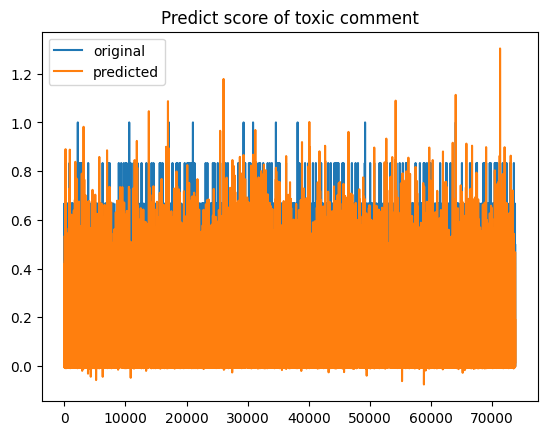

time: 427 ms (started: 2023-02-19 18:46:09 +03:00)


In [ ]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Predict score of toxic comment")
plt.legend()
plt.show()


# Use pipeline it is better so that we no face with error mismatch when test model in our custom data

In [ ]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
#define model
model = XGBRegressor()
#bundle preprocessing and modelling code in pipeline
my_pipeline = Pipeline(steps=[('TFiDF',TfidfVectorizer()),
                              ('model',model)])
#preprocessinf of training data, fit model
my_pipeline.fit(X_train, y_train)
#preprocessing of validation data, get predictions
xgb_preds = my_pipeline.predict(X_test)

time: 22.1 s (started: 2023-02-19 18:46:09 +03:00)


In [ ]:
comment_test = ['Fuck off and shut up kiss my ass shit!']
comment_test_ = ['I love this world and want to kiss and shake hands everyone I see!']

time: 589 µs (started: 2023-02-19 18:46:32 +03:00)


In [ ]:
def test_model(comment_test):
    df_test = pd.DataFrame(comment_test, columns=['comment_test'])
    df_test['comment_test'] = df_test['comment_test'].apply(lambda x:normalization_text(x))
    predict = my_pipeline.predict(df_test['comment_test'])
    return predict

time: 690 µs (started: 2023-02-19 18:46:32 +03:00)


In [ ]:
predict = test_model(comment_test)
predict[0]

0.8804762

time: 25.1 ms (started: 2023-02-19 18:46:32 +03:00)


In [ ]:
predict_ = test_model(comment_test_)
predict_

array([0.02440672], dtype=float32)

time: 45.4 ms (started: 2023-02-19 18:46:37 +03:00)


# Tensorflow

In [ ]:
import tensorflow
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

time: 2.48 ms (started: 2023-02-21 00:05:47 +03:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'].values, df['score'].values, test_size=0.33, random_state=42)


time: 96.3 ms (started: 2023-02-20 02:00:30 +03:00)


In [ ]:
X_train[0]

'michael jackson al littl legend going round obsc websit could ment dea michael jackson mainstream med pick fail wp gng mom talk'

time: 2.17 ms (started: 2023-02-20 02:00:30 +03:00)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
oov_token = '<UNK>'

tokenizer = Tokenizer(num_words=10000) # oov_token=oov_token
tokenizer.fit_on_texts(X_train)

time: 3.63 s (started: 2023-02-20 02:04:48 +03:00)


In [ ]:
word_index = tokenizer.word_index

time: 26.1 ms (started: 2023-02-20 02:04:51 +03:00)


In [ ]:
len(word_index)

120004

time: 3.39 ms (started: 2023-02-20 02:04:51 +03:00)


In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

time: 5.36 s (started: 2023-02-20 02:04:52 +03:00)


In [ ]:
train_sequences

[[1258,
  2208,
  489,
  190,
  2072,
  110,
  1459,
  1715,
  244,
  49,
  91,
  624,
  1258,
  2208,
  1321,
  207,
  1026,
  434,
  65,
  4773,
  707,
  6],
 [377],
 [46,
  288,
  135,
  1160,
  23,
  133,
  8599,
  2209,
  1407,
  6521,
  46,
  3,
  1160,
  109,
  133,
  8599,
  275,
  5474,
  23,
  155,
  4342,
  101,
  153,
  57,
  44,
  64,
  258,
  1716,
  1543,
  27,
  23,
  7,
  1020,
  91,
  205,
  23,
  730,
  3299,
  16,
  3,
  682,
  1391,
  1730],
 [1636, 171, 10, 40, 1636, 171, 114, 467, 362, 114, 36, 200, 282, 19, 18],
 [145,
  741,
  251,
  3087,
  1770,
  1,
  293,
  235,
  450,
  176,
  288,
  651,
  5245,
  136,
  43,
  119,
  132,
  181,
  61,
  66,
  3174,
  76,
  80,
  439,
  296,
  1,
  60,
  487,
  49,
  25,
  382,
  1112,
  73,
  61,
  556,
  296,
  1,
  1601,
  308,
  1601,
  1849,
  5,
  231,
  183,
  4816,
  291,
  1252,
  304,
  358,
  308,
  903,
  604,
  346,
  870,
  5246,
  1849,
  2387,
  4439,
  278,
  73,
  870,
  1713,
  907,
  3049,
  3088,
  108

time: 234 ms (started: 2023-02-20 02:05:20 +03:00)


In [ ]:
maxlen = max([len(x) for x in train_sequences])

time: 18.2 ms (started: 2023-02-20 02:05:23 +03:00)


In [ ]:
maxlen

1426

time: 1.63 ms (started: 2023-02-20 02:05:24 +03:00)


In [ ]:
training_padded = pad_sequences(train_sequences,
                                maxlen=50, 
                                truncating='post', 
                                padding='post'
                               )

time: 320 ms (started: 2023-02-20 02:05:31 +03:00)


In [ ]:
testting_padded = pad_sequences(test_sequences,
                                maxlen=50, 
                                truncating='post', 
                                padding='post'
                               )

time: 162 ms (started: 2023-02-20 02:05:33 +03:00)


In [ ]:
vocab_size = len(word_index)

time: 230 µs (started: 2023-02-20 02:05:35 +03:00)


In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=100)) 
model.add(LSTM(512, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)) 
model.add(LSTM(128, dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(
    loss= 'mean_squared_error',  # tensorflow.keras.metrics.mean_squared_error,
    optimizer='Adam')
    #  metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 128)          15360512  
                                                                 
 lstm_6 (LSTM)               (None, 100, 512)          1312768   
                                                                 
 lstm_7 (LSTM)               (None, 128)               328192    
                                                                 
 dense_6 (Dense)             (None, 16)                2064      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 17,003,553
Trainable params: 17,003,553
Non-trainable params: 0
_________________________________________________________________
time: 803 ms (started: 2023-02-20 00:58:06

In [ ]:
model.fit(training_padded, y_train, epochs = 3, batch_size=128)

In [ ]:
model.save("/Users/miroslav/PycharmProjects/NLP Project/toxic detection/models/model_c")

INFO:tensorflow:Assets written to: /Users/miroslav/PycharmProjects/NLP Project/toxic detection/models/model_c/assets


INFO:tensorflow:Assets written to: /Users/miroslav/PycharmProjects/NLP Project/toxic detection/models/model_c/assets


time: 4.5 s (started: 2023-02-20 15:13:08 +03:00)


In [ ]:
loaded_model = keras.models.load_model('/Users/miroslav/PycharmProjects/NLP Project/toxic detection/models/model_c')

In [ ]:
y_pred = model.predict(testting_padded)

2306/2306 [==============================] - 232s 100ms/step
time: 3min 52s (started: 2023-02-20 00:24:13 +03:00)


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print('mse ----> ', mse)
# root mean squared error
mse_root = mean_squared_error(y_test, y_pred, squared = False)
print('mse_root ----> ', mse_root)

mse ---->  0.013136994283118498
mse_root ---->  0.11461672776309093
time: 53.1 ms (started: 2023-02-20 00:28:08 +03:00)


In [ ]:
# We note quite a high r2_score showing good model performance on the test set.
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print('r2 ----> ', r2)

r2 ---->  0.15374190694994117
time: 5.06 ms (started: 2023-02-20 00:28:11 +03:00)


In [ ]:
comment = ['black fucking nigga']

def preprocessing(tokenizer, comment):
    df_test = pd.DataFrame(comment, columns=['comment_test'])
    df_test['comment_test'] = df_test['comment_test'].apply(lambda x:normalization_text(x))
    comment = df_test['comment_test'].tolist()
    train_sequences = tokenizer.texts_to_sequences(comment)
    training_padded = pad_sequences(train_sequences,
                                maxlen=50, # МИРОСАЛВ: здесь укажи длину в 50
                                truncating='post', 
                                padding='post'
                               )
    return training_padded

test = preprocessing(tokenizer, comment)
y_pred = model.predict(test)
y_pred

array([[ 520,   31, 1373,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

time: 13.8 ms (started: 2023-02-20 00:37:38 +03:00)


# Regression with new model СNN - faster than LSTM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'].values, df['score'].values, test_size=0.33, random_state=42)


time: 414 ms (started: 2023-02-20 14:30:10 +03:00)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
oov_token = '<UNK>'

tokenizer = Tokenizer(num_words=100000) # oov_token=oov_token
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

vocab_size = len(word_index)


maxlen = max([len(x) for x in train_sequences])

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

training_padded = pad_sequences(train_sequences,
                                maxlen=50, # МИРОСАЛВ: здесь укажи длину в 50
                                truncating='post', 
                                padding='post'
                               )

testting_padded = pad_sequences(test_sequences,
                                maxlen=50, # МИРОСАЛВ: здесь укажи длину в 50
                                truncating='post', 
                                padding='post'
                               )

time: 7.03 s (started: 2023-02-20 14:30:11 +03:00)


In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras import regularizers
from keras.layers import Dense, Activation, Dropout, Flatten
from keras import optimizers



vocab_size = len(word_index)

batch_size = 512
num_epochs = 8 

#model parameters
num_filters = 64

weight_decay = 1e-4

kernel_size = 3
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(vocab_size, 512, input_length=50))
model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same', kernel_initializer='normal'))  # kernel_initializer='normal'
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same', kernel_initializer='normal'))  # kernel_initializer='normal'
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))) # kernel_initializer='normal'
model.add(Dense(1, kernel_initializer='normal'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])
model.summary()

training CNN ...
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 50, 512)           61442048  
                                                                 
 conv1d_20 (Conv1D)          (None, 50, 64)            98368     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 25, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 25, 64)            12352     
                                                                 
 global_max_pooling1d_10 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_10 (Dropout)        (None, 

/Users/miroslav/opt/anaconda3/envs/NL/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
# callbacks_list = [early_stopping] # function for stop fitting model when loss is reduce for particular treshhold
batch_size = 256
num_epochs = 8
hist_model = model.fit(training_padded, y_train, batch_size=batch_size, epochs=num_epochs,  validation_split=0.2) #callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/8
469/469 [==============================] - 267s 567ms/step - loss: 0.0076 - rmse: 0.0797 - val_loss: 0.0056 - val_rmse: 0.0721
Epoch 2/8
469/469 [==============================] - 261s 556ms/step - loss: 0.0041 - rmse: 0.0617 - val_loss: 0.0056 - val_rmse: 0.0738
Epoch 3/8
469/469 [==============================] - 233s 497ms/step - loss: 0.0027 - rmse: 0.0507 - val_loss: 0.0055 - val_rmse: 0.0732
Epoch 4/8
469/469 [==============================] - 244s 519ms/step - loss: 0.0021 - rmse: 0.0443 - val_loss: 0.0054 - val_rmse: 0.0726
Epoch 5/8
469/469 [==============================] - 252s 537ms/step - loss: 0.0017 - rmse: 0.0402 - val_loss: 0.0056 - val_rmse: 0.0740
Epoch 6/8
469/469 [==============================] - 242s 515ms/step - loss: 0.0015 - rmse: 0.0375 - val_loss: 0.0056 - val_rmse: 0.0741
Epoch 7/8
469/469 [==============================] - 224s 476ms/step - loss: 0.0013 - rmse: 0.0354 - val_loss: 0.0056 - val_rmse: 0.0746
Epoch 8/8
469/469 [======================

In [ ]:
y_pred = model.predict(testting_padded)

2306/2306 [==============================] - 9s 4ms/step
time: 10.1 s (started: 2023-02-20 15:08:39 +03:00)


In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print('mse ----> ', mse)
# root mean squared error
mse_root = mean_squared_error(y_test, y_pred, squared = False)
print('mse_root ----> ', mse_root)

mse ---->  0.005064422544789027
mse_root ---->  0.0711647563389985
time: 29.6 ms (started: 2023-02-20 15:08:50 +03:00)


In [ ]:
# We note quite a high r2_score showing good model performance on the test set.
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print('r2 ----> ', r2)

r2 ---->  0.6737603387206841
time: 16.9 ms (started: 2023-02-20 15:08:53 +03:00)


In [ ]:
# comment = ['black fucking nigga I kill you I hate you']

# comment = ['Today I learn a lot of maths']

comment = ['fucking!']

# comment = ['I love this world and want to kiss and shake hands everyone I see!']


def preprocessing(tokenizer, comment):
    df_test = pd.DataFrame(comment, columns=['comment_test'])
    df_test['comment_test'] = df_test['comment_test'].apply(lambda x:normalization_text(x))
    comment = df_test['comment_test'].tolist()
    train_sequences = tokenizer.texts_to_sequences(comment)
    training_padded = pad_sequences(train_sequences,
                                maxlen=50, # МИРОСАЛВ: здесь укажи длину в 50
                                truncating='post', 
                                padding='post'
                               )
    return training_padded

test = preprocessing(tokenizer, comment)
y_pred = model.predict(test)
y_pred

1/1 [==============================] - 0s 31ms/step


array([[0.39409852]], dtype=float32)

time: 126 ms (started: 2023-02-20 15:12:10 +03:00)


# Implement classification model in exists dataset
- CNNs provide a faster alternative to LSTM models at a comparable performance. They are faster to train and use fewer parameters. CNN models are translation invariant and in application to text make sense when there is no strong dependence on recent past vs distant past of the input sequence. CNNs can learn patterns in word embeddings and given the nature of the dataset (e.g. multiple misspellings, out of vocabulary words), it makes sense to use sub-word information. In this notebook, a simple CNN architecture is used for multi-label classification with the help of FastText word embeddings. Thus, it can be a good addition (diverse and accurate) to your ensemble.

In [ ]:
df = pd.read_csv('./data/jigsaw-toxic-comment-train.csv')
df['comment_text'] = df['comment_text'].apply(lambda x: normalization_text(x))

In [ ]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

num_classes = len(labels)

X_train, X_test, y_train, y_test = train_test_split(df['comment_text'].values, \
                                                    df[labels].values, test_size=0.33, random_state=42)

time: 106 ms (started: 2023-02-20 01:45:56 +03:00)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
oov_token = '<UNK>'

tokenizer = Tokenizer(num_words=10000) # oov_token=oov_token
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

maxlen = max([len(x) for x in train_sequences])

vocab_size = len(word_index)

batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64

weight_decay = 1e-4

training_padded = pad_sequences(train_sequences,
                                maxlen=50, # МИРОСАЛВ: здесь укажи длину в 50
                                truncating='post', 
                                padding='post'
                               )

testting_padded = pad_sequences(test_sequences,
                                maxlen=50, # МИРОСАЛВ: здесь укажи длину в 50
                                truncating='post', 
                                padding='post'
                               )

time: 9.16 s (started: 2023-02-20 01:16:46 +03:00)


In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras import regularizers
from keras.layers import Dense, Activation, Dropout, Flatten
from keras import optimizers

#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=50))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 128)           15360512  
                                                                 
 conv1d (Conv1D)             (None, 50, 64)            57408     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 64)            28736     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 6

/Users/miroslav/opt/anaconda3/envs/NL/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

hist = model.fit(training_padded, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Epoch 1/8
527/527 - 45s - loss: 0.1026 - accuracy: 0.8239 - val_loss: 0.0657 - val_accuracy: 0.9955 - 45s/epoch - 86ms/step
Epoch 2/8
527/527 - 43s - loss: 0.0606 - accuracy: 0.9845 - val_loss: 0.0632 - val_accuracy: 0.9955 - 43s/epoch - 82ms/step
Epoch 3/8
527/527 - 41s - loss: 0.0541 - accuracy: 0.9919 - val_loss: 0.0652 - val_accuracy: 0.9955 - 41s/epoch - 77ms/step
Epoch 4/8
527/527 - 40s - loss: 0.0484 - accuracy: 0.9945 - val_loss: 0.0679 - val_accuracy: 0.9955 - 40s/epoch - 76ms/step
Epoch 5/8
527/527 - 40s - loss: 0.0430 - accuracy: 0.9937 - val_loss: 0.0710 - val_accuracy: 0.9955 - 40s/epoch - 76ms/step
Epoch 5: early stopping
time: 3min 29s (started: 2023-02-20 01:18:26 +03:00)


In [ ]:
y_pred = model.predict(testting_padded)

2306/2306 [==============================] - 9s 4ms/step
time: 8.96 s (started: 2023-02-20 01:42:21 +03:00)


In [ ]:
submission_df = pd.DataFrame(columns=labels)
# submission_df['id'] = test_df['id'].values 
submission_df[labels] = y_pred 
submission_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.849997,1.756194e-02,4.869022e-01,8.071026e-03,4.943621e-01,3.321489e-02
1,0.000001,2.136102e-13,4.470760e-08,2.885862e-12,8.801433e-09,9.799035e-11
2,0.867622,1.743926e-01,5.957840e-01,1.704855e-01,5.625650e-01,3.044776e-01
3,0.241682,1.519084e-04,2.044289e-02,4.227823e-04,2.200881e-02,1.739258e-03
4,0.000380,2.746998e-09,1.833829e-05,2.162285e-08,8.950958e-06,2.437045e-07
...,...,...,...,...,...,...
73767,0.045701,6.278895e-05,4.883371e-03,2.501438e-04,4.228549e-03,8.493444e-04
73768,0.094600,6.993089e-04,1.667992e-02,2.903034e-03,1.679722e-02,5.211209e-03
73769,0.007894,6.462674e-06,1.000149e-03,3.341530e-05,6.890298e-04,1.150988e-04
73770,0.263234,6.779019e-04,4.217507e-02,1.621079e-03,4.427062e-02,5.180608e-03


time: 32.9 ms (started: 2023-02-20 01:42:32 +03:00)


In [ ]:
hist.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x7f9cc2aa3580>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.10264328122138977,
   0.06062068045139313,
   0.054146114736795425,
   0.04837951064109802,
   0.04298679530620575],
  'accuracy': [0.8238933682441711,
   0.984480619430542,
   0.991913914680481,
   0.9944584369659424,
   0.9936794638633728],
  'val_loss': [0.06569772958755493,
   0.06324321776628494,
   0.06521186977624893,
   0.0678744837641716,
   0.07103971391916275],
  'val_accuracy': [0.9955267906188965,
   0.9955267906188965,
   0.9955267906188965,
   0.9955267906188965,
   0.9955267906188965]},
 'params': {'verbose': 2, 'epochs': 8, 'steps': 527},
 'epoch': [0, 1, 2, 3, 4]}

time: 5.93 ms (started: 2023-02-20 01:39:54 +03:00)


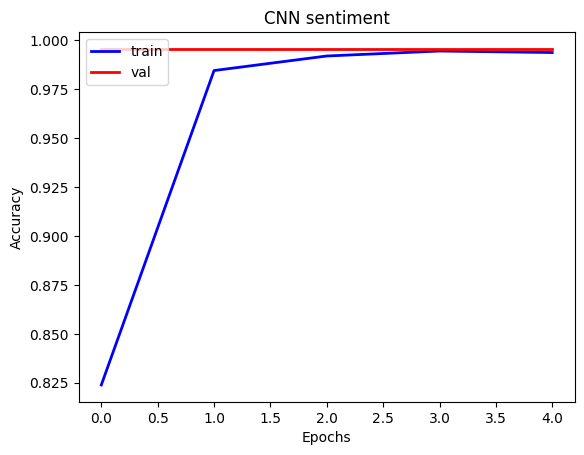

time: 258 ms (started: 2023-02-20 01:50:17 +03:00)


In [ ]:
plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# USE TFIDF vectorize for predicting scores

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'].values, df['score'].values, test_size=0.33, random_state=42)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
import tensorflow as tf

oov_token = '<UNK>'

vocab_size = 50

tfidf_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='tf-idf',
    ngrams=(1, 2)
)

tfidf_vectorizer.adapt(X_train)


time: 14.7 s (started: 2023-02-21 00:42:01 +03:00)


In [ ]:
tfidf_vectorizer.get_vocabulary()[:1]
tfidf_vectorizer.vocabulary_size()
print(tfidf_vectorizer(['Hi how are you']))

tf.Tensor(
[[17.82208  0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.     ]], shape=(1, 50), dtype=float32)
time: 21.5 ms (started: 2023-02-21 00:42:17 +03:00)


In [ ]:
def preprocessing(comment):
    df_test = pd.DataFrame(comment, columns=['comment_test'])
    df_test['comment_test'] = df_test['comment_test'].apply(lambda x:normalization_text(x))
    comment = df_test['comment_test'].tolist()
    return comment
comment = ['I hate you black fucking nigga']
test = preprocessing(comment)
y_pred = model.predict(test)
y_pred

1/1 [==============================] - 0s 31ms/step


array([[0.04316227]], dtype=float32)

time: 83.6 ms (started: 2023-02-21 00:34:58 +03:00)


In [ ]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras import regularizers
from keras.layers import Dense, Activation, Dropout, Flatten
from keras import optimizers


batch_size = 512
num_epochs = 8 

#model parameters
num_filters = 64

weight_decay = 1e-4

kernel_size = 3
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(tfidf_vectorizer)
model.add(Embedding(vocab_size, 64, input_length=50))
model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same', kernel_initializer='normal'))  # kernel_initializer='normal'
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same', kernel_initializer='normal'))  # kernel_initializer='normal'
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay))) # kernel_initializer='normal'
model.add(Dense(1, kernel_initializer='normal'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=[tensorflow.keras.metrics.RootMeanSquaredError(name='rmse')])
model.summary()

training CNN ...
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 50)               1         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 50, 64)            3200      
                                                                 
 conv1d_8 (Conv1D)           (None, 50, 64)            12352     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 25, 64)            12352     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 

In [ ]:
256/2/2

64.0

time: 2.96 ms (started: 2023-02-21 00:36:25 +03:00)
